# Convert Li2024 seismic to VTK

In [2]:
# =============================================================================
# Imports
# =============================================================================
from pathlib import Path
import numpy as np
import pandas as pd
from scipy import interpolate
import geopandas as gpd
from pyevtk.hl import gridToVTK, pointsToVTK


# =============================================================================

In [3]:
units = "m"
epsg = 32610

In [4]:
fn = Path(
    r"c:\Users\jpeacock\OneDrive - DOI\ClearLake\2022_qi_seismic_model_ClearLake\ModelinGEOS"
)

In [5]:
df = pd.read_csv(
    fn,
    sep="\s+",
    header=None,
    usecols=[0, 1, 2, 3, 5],
    names=["lon", "lat", "z", "vp", "moho"],
)

In [6]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs=4326)

In [15]:
gdf.columns

Index(['lon', 'lat', 'z', 'vp', 'moho', 'geometry'], dtype='object')

In [46]:
# clip the gdf to the area of interest
gdf_clip = gdf[
    (gdf.lat <= 39.5)
    & (gdf.lat >= 38.5)
    & (gdf.lon <= -122.15)
    & (gdf.lon >= -123.25)
]

In [47]:
utm_gdf = gdf_clip.to_crs(epsg=32610)
utm_gdf["easting"] = utm_gdf.geometry.x
utm_gdf["northing"] = utm_gdf.geometry.y

In [48]:
dx = int((utm_gdf.easting.max() - utm_gdf.easting.min()) / 500)
dy = int((utm_gdf.northing.max() - utm_gdf.northing.min()) / 500)

print(f"dx: {dx}\ndy: {dy}")

dx: 191
dy: 222


In [49]:
x = np.linspace(utm_gdf.easting.min(), utm_gdf.easting.max(), dx + 1)
y = np.linspace(utm_gdf.northing.min(), utm_gdf.northing.max(), dy + 1)
depth = np.append(utm_gdf.z.unique() * 1000 * -1, [36000])

nx = x.size
ny = y.size
nz = depth.size

In [50]:
# interpolate onto a regular grid
new_vp = np.zeros((dx, dy, depth.size - 1))
for index, z in enumerate(utm_gdf.z.unique()):
    zdf = utm_gdf[utm_gdf.z == z]


    new_vp[:, :, index] = interpolate.griddata(
        (zdf.easting.to_numpy(), zdf.northing.to_numpy()),
        zdf.vp,
        (x[:-1, None], y[None, :-1]),
    )

In [51]:
# estimate vp/vs
cell_data = {"vp": new_vp}

gridToVTK(
    fn.parent.joinpath("2024_li_vp").as_posix(),
    x,
    y,
    depth,
    cellData=cell_data,
)

'c:\\Users\\jpeacock\\OneDrive - DOI\\ClearLake\\2022_qi_seismic_model_ClearLake\\2024_li_vp.vtr'

<Axes: xlabel='easting', ylabel='northing'>

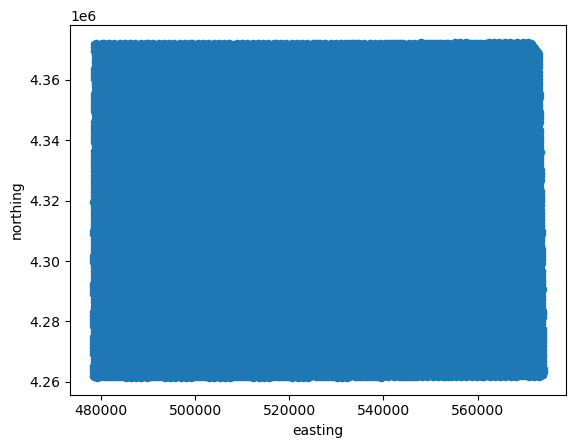

In [52]:
zdf.plot.scatter("easting", "northing")